<a href="https://colab.research.google.com/github/HarlinLee/cogsci-missed-connections/blob/main/citation_context_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle

In [2]:
!pip install python-louvain
from community import community_louvain

In [3]:
from google.colab import drive
drive.mount('/content/drive') 
DRIVE_PATH = "/content/drive/My Drive/REU evolution of scientific fields"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [4]:
with open(os.path.join(DRIVE_PATH, 'filtered_new_fields_df.pkl'), 'rb') as file:
    fields_df = pickle.load(file)
print(fields_df.shape)

(59384, 18)


# Build Citation Network

In [5]:
id_set = set(fields_df['Id'])

In [6]:
def filter_set(x):
  if isinstance(x, list):
    return list(set(x).intersection(id_set))
  else:
    return []

fields_df['filtered_id'] = fields_df['RId'].apply(lambda x: filter_set(x))

In [7]:
adj_dict = dict(zip(fields_df['Id'],fields_df['filtered_id'].apply(lambda x: dict(zip(x,[{}] * len(x))))))

G = nx.DiGraph(adj_dict)
len(G), G.size()

(59384, 191871)

# Community detection

In [8]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
K = G.subgraph(largest_cc)
print(len(K), K.size())
K_undirected=nx.to_undirected(K)

41465 190997


In [9]:
c = community_louvain.best_partition(K_undirected, random_state=0) 

In [10]:
community_dict = {}
for i in c.keys():
  community_dict[c[i]] = community_dict.get(c[i], []) + [i]

# Sort by size

[4353 4003 3976 3371 3082 2659 2657 2350 2224 2161 2159 1963 1829 1167
  969  493  477  278  266  257  245  173   68   53   33   18   17   17
   17   16   14   14   12   11   10    9    8    8    7    6    6    5
    4]


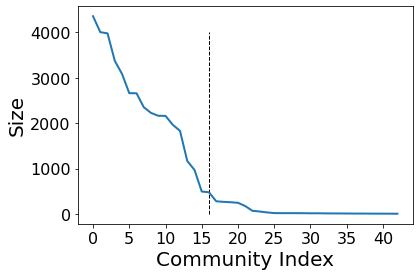

In [11]:
length_list = np.array([len(community_dict[ii]) for ii in range(len(community_dict.keys()))])

sort_idx = np.argsort(length_list)[::-1]
print(length_list[sort_idx])

plt.figure(figsize=(6,4))
plt.plot(length_list[sort_idx], linewidth=2)
plt.vlines(16, 0, 4000, linestyles='--', linewidth=1)
plt.xlabel('Community Index',fontsize=20)
plt.ylabel('Size',fontsize=20)
plt.tick_params(labelsize=16)
plt.yticks(range(0,4500, 1000))
plt.xticks(range(0,45, 5))
plt.savefig(DRIVE_PATH+'/'+'CommunitySize.pdf',bbox_inches='tight')
plt.show()

In [12]:
comm_id_sort = dict(zip(range(len(length_list)), sort_idx))
comm_id_sort_reverse = dict(zip(sort_idx, range(len(length_list))))

In [13]:
community_dict_sorted = {}
for ii in range(len(length_list)):
  community_dict_sorted[ii] = community_dict[comm_id_sort[ii]]

In [14]:
# save
np.savez(DRIVE_PATH +'/comm_detection.npz', 
         community_dict_sorted=community_dict_sorted, 
         comm_id_sort=comm_id_sort, 
         comm_id_sort_reverse=comm_id_sort_reverse,
         c=c, allow_pickle=True)

